In [ ]:
!pip install langchain_openai joblib pandas matplotlib

In [74]:
import time, requests
from langchain_openai import ChatOpenAI
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Check that URL is correct
assert requests.get(url + "/health").status_code == 200

def make_request():
    llm = ChatOpenAI(
        base_url=url + "/v1/",
        model=model,
        openai_api_key="not-used",
    )
    timings = []
    for r in range(request_per_client):
        start_time = time.time()
        results = llm.invoke("Hello, how are you?")
        timings.append(time.time() - start_time)
    return timings

def run_perf_test(url, model, clients, requests_per_client):

    avg_timings = []
    for clients in tqdm(clients):
        for request_per_client in requests_per_client:
            result = Parallel(n_jobs=clients)(delayed(make_request)() for i in range(clients))
            for ts in result:
                avg_timings.append({"clients": clients, "requests_per_client": request_per_client, "avg_t": sum(ts) / len(ts)})

    df = pd.DataFrame.from_records(avg_timings)
    data = df.groupby(['clients', 'requests_per_client']).mean().reset_index()

    fig, ax = plt.subplots()
    for c in data.clients.unique():
        _data = data[data.clients == c]
        ax.plot(_data.requests_per_client, _data.avg_t, label=c)

    ax.set_ylabel("Avg response time (seconds)")
    ax.legend(title="Clients");

    return fig, ax

100%|██████████| 3/3 [01:43<00:00, 34.41s/it]


(<Figure size 640x480 with 1 Axes>,
 <Axes: ylabel='Avg response time (seconds)'>)

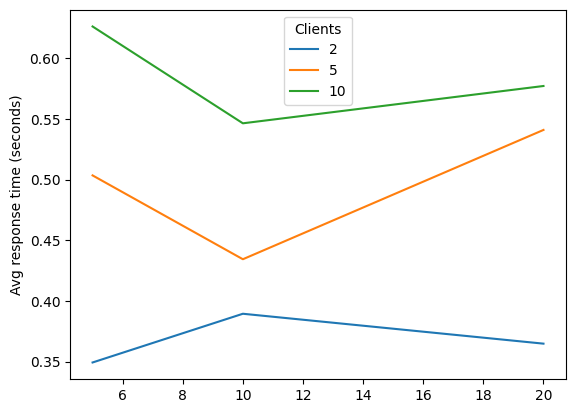

In [77]:
url = "http://llm-backend.default.svc"
model = "ise-uiuc/Magicoder-S-DS-6.7B"
run_perf_test(url, model, [2, 5, 10], [5, 10, 20])
# run_perf_test(url, model, [2, 5, 10, 20], [5, 10, 20])

100%|██████████| 3/3 [12:31<00:00, 250.61s/it]


(<Figure size 640x480 with 1 Axes>,
 <Axes: ylabel='Avg response time (seconds)'>)

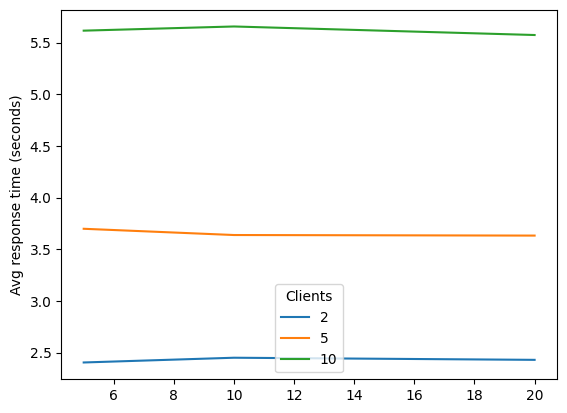

In [78]:
url = "http://llm-backend.scott-test-2.svc"
model = "TheBloke/SauerkrautLM-70B-v1-AWQ"

run_perf_test(url, model, [2, 5, 10], [5, 10, 20])